<a href="https://colab.research.google.com/github/dyna-bytes/PyTorchIntensive/blob/main/3_1_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics torchviz

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

import pytorch_lightning as pl

from pytorch_lightning.accelerators import accelerator
from torchmetrics import functional as FM
from torchinfo import summary

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]

torch.__version__,pl.__version__

('2.0.1+cu118', '2.0.3')

In [ ]:
## GPU check
torch.cuda.is_available(),torch.cuda.device_count(),torch.cuda.device(0),torch.cuda.get_device_name(0)

(True, 1, <torch.cuda.device at 0x7fdd74cfca00>, 'Tesla T4')

(True, 1, <torch.cuda.device at 0x7fedac677160>, 'Tesla T4')
(True, 1, <torch.cuda.device at 0x7f9145233250>, 'Tesla V100-SXM2-16GB')


## MLP, CNN Parameter 비교

In [ ]:
#device ='cuda:0'

In [ ]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(), # 255로 나누어주고 tensor로 변환
])

_batch_size = 128
download_root = ''
train_dataset = MNIST(download_root, train=True, download=True, transform=mnist_transform)
test_dataset = MNIST(download_root, train=False, download=True, transform=mnist_transform)
trainDataLoader = DataLoader(train_dataset, _batch_size, True)
valDataLoader = DataLoader(test_dataset, _batch_size, False)

100%|██████████| 9912422/9912422 [00:00<00:00, 138336698.09it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 156102698.23it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 69279460.23it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8179703.21it/s]


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



[] Shapetorch.Size([60000, 28, 28]), <class 'torch.Tensor'>
[] Shapetorch.Size([60000]), <class 'torch.Tensor'>


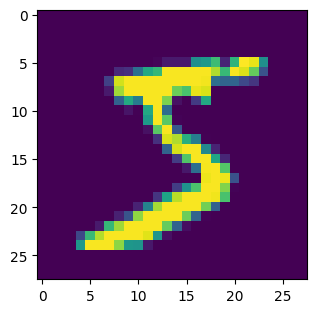

In [ ]:
pst(trainDataLoader.dataset.data)    # image
pst(trainDataLoader.dataset.targets) # label
plt.imshow(trainDataLoader.dataset.data[0])
plt.show()

In [ ]:
batch_n = len(trainDataLoader.dataset.data) // _batch_size
batch_n

468

### MLP Model

In [ ]:
# MLP model
class MLP(pl.LightningModule):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(  # Container
            nn.Flatten(),
            nn.Linear(28*28, 384),
            nn.ReLU(),
            nn.Linear(384, 10))

    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics,prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

mlp = MLP()
summary(mlp, input_size=(_batch_size, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Flatten: 2-1                      [128, 784]                --
│    └─Linear: 2-2                       [128, 384]                301,440
│    └─ReLU: 2-3                         [128, 384]                --
│    └─Linear: 2-4                       [128, 10]                 3,850
Total params: 305,290
Trainable params: 305,290
Non-trainable params: 0
Total mult-adds (M): 39.08
Input size (MB): 0.40
Forward/backward pass size (MB): 0.40
Params size (MB): 1.22
Estimated Total Size (MB): 2.03

In [ ]:
%%time
mlp = MLP()

_epochs = 10
name="mlp"
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=_epochs, logger=logger, accelerator="auto",
                     limit_train_batches=0.4, limit_val_batches=0.2)
trainer.fit(mlp, trainDataLoader, valDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 305 K 
--------------------------------------
305 K     Trainable params
0         Non-trainable params
305 K     Total params
1.221     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 39.7 s, sys: 297 ms, total: 40 s
Wall time: 39.8 s


In [ ]:
v_num = logger.version
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')
df = history.groupby('epoch').last().drop('step', axis=1)

In [ ]:
print('MaxAcc:[',df['val_acc'].max(),']')

fig = plt.figure(figsize = (10, 3))
plt.subplot(121)
plt.plot(df['acc'], linestyle='-', label="acc")
plt.plot(df['val_acc'], linestyle='--', label="val_acc")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(df['loss'], linestyle='-', label="loss")
plt.plot(df['val_loss'], linestyle='--', label="val_loss")

plt.legend()
plt.grid()
plt.show()

MaxAcc:[ 0.9697916507720948 ]
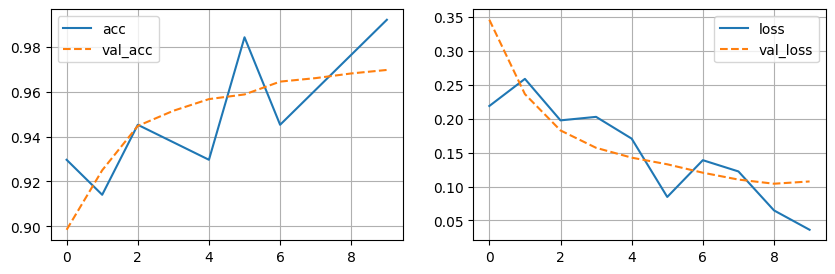

### CNN Model

In [ ]:
# Convolutional model
loss_f = nn.CrossEntropyLoss()
class CNN(pl.LightningModule):
    def __init__(self):
        super(CNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 48, (3, 3), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(48*6*6, 10)
            )

    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics,prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

cnn = CNN()
summary(cnn, input_size=(_batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Conv2d: 2-1                       [128, 32, 13, 13]         320
│    └─ReLU: 2-2                         [128, 32, 13, 13]         --
│    └─Conv2d: 2-3                       [128, 48, 6, 6]           13,872
│    └─ReLU: 2-4                         [128, 48, 6, 6]           --
│    └─Flatten: 2-5                      [128, 1728]               --
│    └─Linear: 2-6                       [128, 10]                 17,290
Total params: 31,482
Trainable params: 31,482
Non-trainable params: 0
Total mult-adds (M): 73.06
Input size (MB): 0.40
Forward/backward pass size (MB): 7.32
Params size (MB): 0.13
Estimated Total Size (MB): 7.84

In [ ]:
%%time
cnn = CNN()

name="cnn"
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=_epochs, logger=logger, accelerator="auto",
                     limit_train_batches=0.4,limit_val_batches=0.2)
trainer.fit(cnn, trainDataLoader, val_dataloaders=valDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 31.5 K
--------------------------------------
31.5 K    Trainable params
0         Non-trainable params
31.5 K    Total params
0.126     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 40.1 s, sys: 297 ms, total: 40.4 s
Wall time: 40.2 s


In [ ]:
v_num = logger.version
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')
df = history.groupby('epoch').last().drop('step', axis=1)

In [ ]:
print('MaxAcc:[',df['val_acc'].max(),']')

fig = plt.figure(figsize = (10, 3))
plt.subplot(121)
plt.plot(df['acc'], linestyle='-', label="acc")
plt.plot(df['val_acc'], linestyle='--', label="val_acc")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(df['loss'], linestyle='-', label="loss")
plt.plot(df['val_loss'], linestyle='--', label="val_loss")

plt.legend()
plt.grid()
plt.show()

# 실습과제1 MNIST
LeNet-5와 유사한 모델을 만들어보자
- 모델을 개선하여 10epoch 학습 최고 성능이 되도록 하자

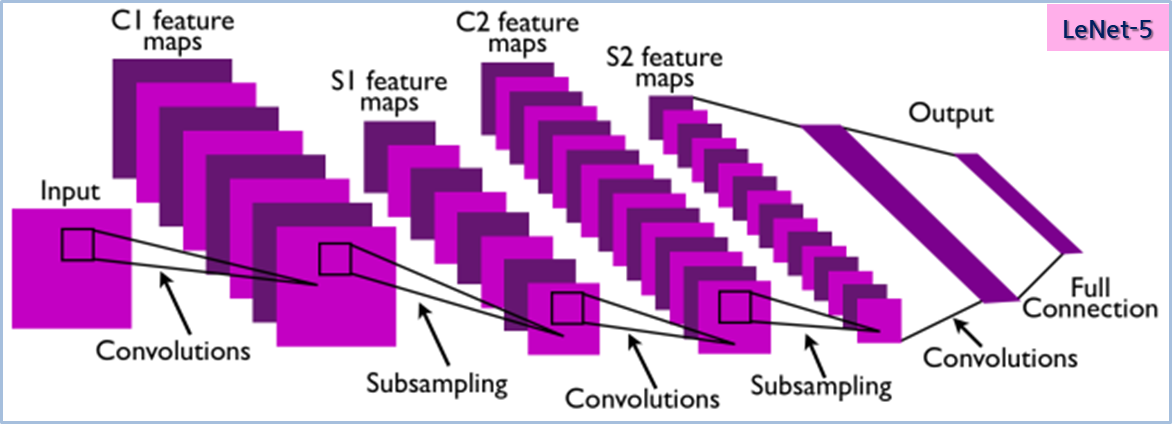

## LeNet like

In [ ]:
# LeNet like model
class LeNet_like(pl.LightningModule):
    def __init__(self):
        super(LeNet_like, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 8, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(8, 16, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(32*3*3, 10)
        )
    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

LeNet = LeNet_like()
summary(LeNet, input_size=(_batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet_like                               [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Conv2d: 2-1                       [128, 8, 28, 28]          80
│    └─ReLU: 2-2                         [128, 8, 28, 28]          --
│    └─MaxPool2d: 2-3                    [128, 8, 14, 14]          --
│    └─Conv2d: 2-4                       [128, 16, 14, 14]         1,168
│    └─ReLU: 2-5                         [128, 16, 14, 14]         --
│    └─MaxPool2d: 2-6                    [128, 16, 7, 7]           --
│    └─Conv2d: 2-7                       [128, 32, 7, 7]           4,640
│    └─ReLU: 2-8                         [128, 32, 7, 7]           --
│    └─MaxPool2d: 2-9                    [128, 32, 3, 3]           --
│    └─Flatten: 2-10                     [128, 288]                --
│    └─Linear: 2-11                      [128, 10]                 2,890
Total 

In [ ]:
LeNet = LeNet_like()

_epochs=10
name="lenet"
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=_epochs, logger=logger, accelerator="auto",
                     limit_train_batches=0.4,limit_val_batches=0.2)
trainer.fit(LeNet, trainDataLoader, valDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 8.8 K 
--------------------------------------
8.8 K     Trainable params
0         Non-trainable params
8.8 K     Total params
0.035     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
v_num = logger.version ## LeNet.get_progress_bar_dict()['v_num']
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')
df = history.groupby('epoch').last().drop('step', axis=1)

MaxAcc:[ 0.9791666865348816 ]


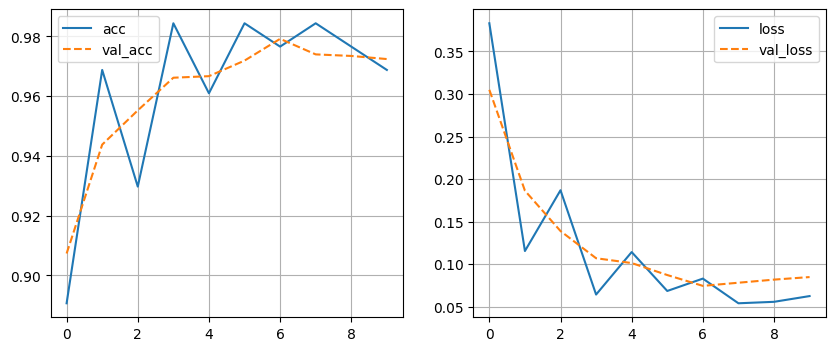

In [ ]:
print('MaxAcc:[',df['val_acc'].max(),']')

fig = plt.figure(figsize = (10, 4))
plt.subplot(121)
plt.plot(df['acc'], linestyle='-', label="acc")
plt.plot(df['val_acc'], linestyle='--', label="val_acc")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(df['loss'], linestyle='-', label="loss")
plt.plot(df['val_loss'], linestyle='--', label="val_loss")

plt.legend()
plt.grid()
plt.show()

# 실습과제2 CIFAR-10

CIFAR-10 Datasetd을 적용해 보자
- 앞에서 만든 모델에 적용하자
== input data shape (3,32,32)으로 수정하자
== 모델을 개선하여 10epoch 에서 accuracy 70%를 넘겨 보자

In [ ]:
from torchvision.datasets import CIFAR10, CIFAR100
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transformToTensor = transforms.Compose([
    transforms.ToTensor(),
])

epochs=3
batch_size=1024

download_root = './CIFAR10'
cifar10_train = CIFAR10(download_root, transform=transformToTensor, train=True, download=True)
cifar10_test = CIFAR10(download_root, transform=transformToTensor, train=True, download=True)
c10TrainDataLoader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
c10ValDataLoader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:09<00:00, 18884707.02it/s]


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


[] Shape(50000, 32, 32, 3), <class 'numpy.ndarray'>


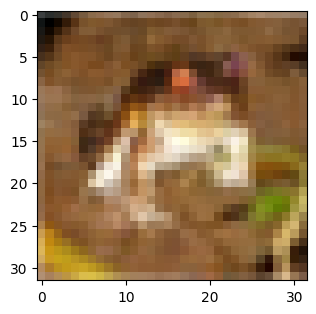

In [ ]:
pst(c10TrainDataLoader.dataset.data)    # image
# pst(c10TrainDataLoader.dataset.targets) # label
plt.imshow(c10TrainDataLoader.dataset.data[0])
plt.show()

## LeNet like 1

In [ ]:
# LeNet like model
class LeNet_like(pl.LightningModule):
    def __init__(self):
        super(LeNet_like, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, (3, 3), padding=1),
            nn.PReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, (3, 3), padding=1),
            nn.PReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, (3, 3), padding=1),
            nn.PReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(128*4*4, 128),
            nn.PReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

LeNet = LeNet_like()
summary(LeNet, input_size=(_batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet_like                               [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Conv2d: 2-1                       [128, 32, 32, 32]         896
│    └─PReLU: 2-2                        [128, 32, 32, 32]         1
│    └─MaxPool2d: 2-3                    [128, 32, 16, 16]         --
│    └─Conv2d: 2-4                       [128, 64, 16, 16]         18,496
│    └─PReLU: 2-5                        [128, 64, 16, 16]         1
│    └─MaxPool2d: 2-6                    [128, 64, 8, 8]           --
│    └─Conv2d: 2-7                       [128, 128, 8, 8]          73,856
│    └─PReLU: 2-8                        [128, 128, 8, 8]          1
│    └─MaxPool2d: 2-9                    [128, 128, 4, 4]          --
│    └─Flatten: 2-10                     [128, 2048]               --
│    └─Linear: 2-11                      [128, 128]                262,272
│   

In [ ]:
LeNet = LeNet_like()

_epochs=10
name="lenet"
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=_epochs, logger=logger, accelerator="auto",
                     limit_train_batches=0.4,limit_val_batches=0.2)
trainer.fit(LeNet, c10TrainDataLoader, c10ValDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 356 K 
--------------------------------------
356 K     Trainable params
0         Non-trainable params
356 K     Total params
1.427     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
v_num = logger.version ## LeNet.get_progress_bar_dict()['v_num']
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')
df = history.groupby('epoch').last().drop('step', axis=1)

MaxAcc:[ 0.5609809160232544 ]


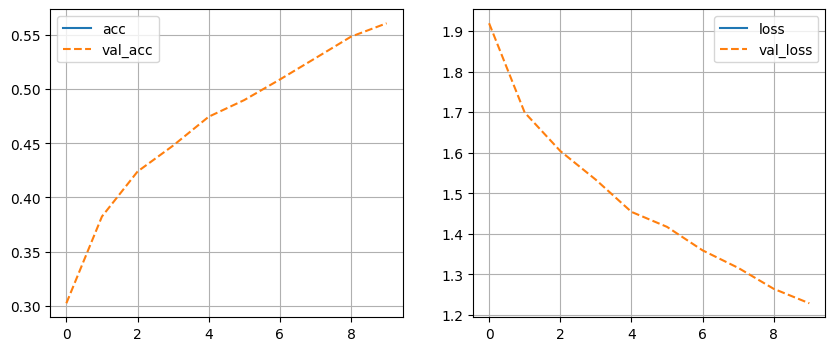

In [ ]:
print('MaxAcc:[',df['val_acc'].max(),']')

fig = plt.figure(figsize = (10, 4))
plt.subplot(121)
plt.plot(df['acc'], linestyle='-', label="acc")
plt.plot(df['val_acc'], linestyle='--', label="val_acc")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(df['loss'], linestyle='-', label="loss")
plt.plot(df['val_loss'], linestyle='--', label="val_loss")

plt.legend()
plt.grid()
plt.show()

## LeNet like 2

In [ ]:
# LeNet like model
class LeNet_like(pl.LightningModule):
    def __init__(self):
        super(LeNet_like, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 128, (3, 3), padding=1),
            nn.PReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, (3, 3), padding=1),
            nn.PReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(256, 512, (3, 3), padding=1),
            nn.PReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(512*4*4, 128),
            nn.PReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

LeNet = LeNet_like()
summary(LeNet, input_size=(_batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet_like                               [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Conv2d: 2-1                       [128, 128, 32, 32]        3,584
│    └─PReLU: 2-2                        [128, 128, 32, 32]        1
│    └─MaxPool2d: 2-3                    [128, 128, 16, 16]        --
│    └─Conv2d: 2-4                       [128, 256, 16, 16]        295,168
│    └─PReLU: 2-5                        [128, 256, 16, 16]        1
│    └─MaxPool2d: 2-6                    [128, 256, 8, 8]          --
│    └─Conv2d: 2-7                       [128, 512, 8, 8]          1,180,160
│    └─PReLU: 2-8                        [128, 512, 8, 8]          1
│    └─MaxPool2d: 2-9                    [128, 512, 4, 4]          --
│    └─Flatten: 2-10                     [128, 8192]               --
│    └─Linear: 2-11                      [128, 128]                1,048,

In [ ]:
LeNet = LeNet_like()

_epochs=10
name="lenet"
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=_epochs, logger=logger, accelerator="auto",
                     limit_train_batches=0.4,limit_val_batches=0.2)
trainer.fit(LeNet, c10TrainDataLoader, c10ValDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 2.5 M 
--------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.116    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
v_num = logger.version ## LeNet.get_progress_bar_dict()['v_num']
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')
df = history.groupby('epoch').last().drop('step', axis=1)

MaxAcc:[ 0.6929253339767456 ]


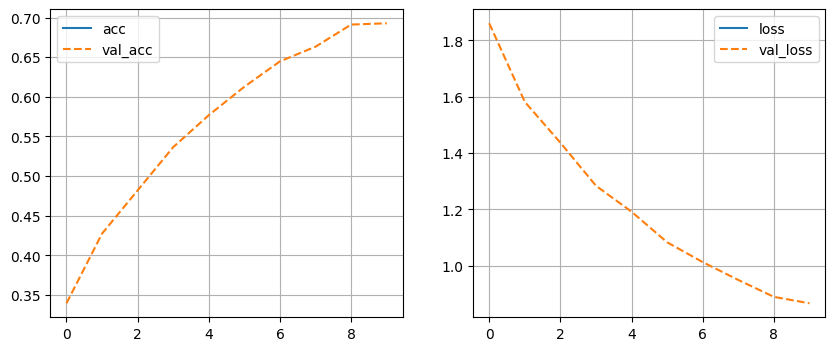

In [ ]:
print('MaxAcc:[',df['val_acc'].max(),']')

fig = plt.figure(figsize = (10, 4))
plt.subplot(121)
plt.plot(df['acc'], linestyle='-', label="acc")
plt.plot(df['val_acc'], linestyle='--', label="val_acc")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(df['loss'], linestyle='-', label="loss")
plt.plot(df['val_loss'], linestyle='--', label="val_loss")

plt.legend()
plt.grid()
plt.show()

## LeNet like 3

In [ ]:
# LeNet like model
class LeNet_like(pl.LightningModule):
    def __init__(self):
        super(LeNet_like, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 128, (3, 3), padding=1),
            nn.PReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, (3, 3), padding=1),
            nn.PReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(256, 512, (3, 3), padding=1),
            nn.PReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(512, 1024, (3, 3), padding=1),
            nn.PReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(1024*2*2, 10)
        )
    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

LeNet = LeNet_like()
summary(LeNet, input_size=(_batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet_like                               [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Conv2d: 2-1                       [128, 128, 32, 32]        3,584
│    └─PReLU: 2-2                        [128, 128, 32, 32]        1
│    └─MaxPool2d: 2-3                    [128, 128, 16, 16]        --
│    └─Conv2d: 2-4                       [128, 256, 16, 16]        295,168
│    └─PReLU: 2-5                        [128, 256, 16, 16]        1
│    └─MaxPool2d: 2-6                    [128, 256, 8, 8]          --
│    └─Conv2d: 2-7                       [128, 512, 8, 8]          1,180,160
│    └─PReLU: 2-8                        [128, 512, 8, 8]          1
│    └─MaxPool2d: 2-9                    [128, 512, 4, 4]          --
│    └─Conv2d: 2-10                      [128, 1024, 4, 4]         4,719,616
│    └─PReLU: 2-11                       [128, 1024, 4, 4]        

In [ ]:
LeNet = LeNet_like()

_epochs=10
name="lenet"
logger = pl.loggers.CSVLogger("logs", name=name)
trainer = pl.Trainer(max_epochs=_epochs, logger=logger, accelerator="auto",
                     limit_train_batches=0.4,limit_val_batches=0.2)
trainer.fit(LeNet, c10TrainDataLoader, c10ValDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 6.2 M 
--------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params
24.958    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
v_num = logger.version ## LeNet.get_progress_bar_dict()['v_num']
history = pd.read_csv(f'./logs/{name}/version_{v_num}/metrics.csv')
df = history.groupby('epoch').last().drop('step', axis=1)

MaxAcc:[ 0.7076823115348816 ]


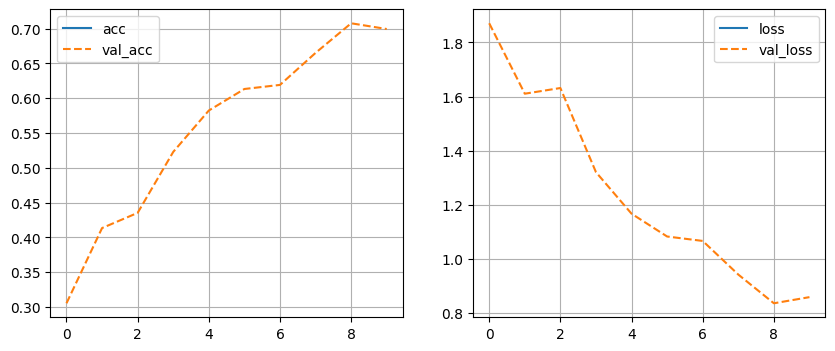

In [ ]:
print('MaxAcc:[',df['val_acc'].max(),']')

fig = plt.figure(figsize = (10, 4))
plt.subplot(121)
plt.plot(df['acc'], linestyle='-', label="acc")
plt.plot(df['val_acc'], linestyle='--', label="val_acc")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(df['loss'], linestyle='-', label="loss")
plt.plot(df['val_loss'], linestyle='--', label="val_loss")

plt.legend()
plt.grid()
plt.show()